# Vector embedding with `gensim`

Let's make use of deep learning through a technique called *embedding* -- to analyze the relatedness of the labels used for recipe ingredients.

Among the most closely related ingredients:

  * Some are very close synonyms and should be consolidated to improve data quality
  * Others are interesting other ingredients that pair frequently, useful for recommendations

On the one hand, this approach is quite helpful for analyzing the NLP annotations that go into a knowledge graph.
On the other hand it can be used along with [`SKOS`](https://www.w3.org/2004/02/skos/) or similar vocabularies for ontology-based discovery within the graph, e.g., for advanced search UI.

## Curating annotations

We'll be working with the labels for ingredients that go into our KG.
Looking at the raw data, there are many cases where slightly different spellings are being used for the same entity.

As a first step let's define a list of synonyms to substitute, prior to running the vector embedding.
This will help produce better quality results.

Note that this kind of work comes of the general heading of *curating annotations* ... which is what we spend so much time doing in KG work.
It's similar to how *data preparation* is ~80% of the workload for data science teams, and for good reason.

In [1]:
SYNONYMS = {
    "egg": "egg",
    "eggs": "egg",

    "vanilla": "vanilla",
    "vanilla extract": "vanilla",

    "onions": "onion",
    "onion": "onion",
        
    "carrots": "carrot",
    "carrot": "carrot",

    "potatoes": "potato",
    "potato": "potato",
    
    "tomatoes": "tomato",
    "fresh tomatoes": "tomato",
    "fresh tomato": "tomato",
    
    "garlic": "garlic",
    "garlic clove": "garlic",
    "garlic cloves": "garlic",
}

## Analyze ingredient labels from 250K recipes

In [2]:
import csv

MAX_ROW = 250000 # 231638

max_context = 0
min_context = 1000

recipes = []
vocab = set()

with open("dat/all_ind.csv", "r") as f:
    reader = csv.reader(f)
    next(reader, None) # remove file header

    for i, row in enumerate(reader):
        id = row[0]
        ind_set = set()
        
        # substitute synonyms
        for ind in set(eval(row[1])):
            if ind in SYNONYMS:
                ind_set.add(SYNONYMS[ind])
            else:
                ind_set.add(ind)
        
        if len(ind_set) > 1:
            recipes.append([id, ind_set])
            vocab.update(ind_set)
        
            max_context = max(max_context, len(ind_set))
            min_context = min(min_context, len(ind_set))

        if i > MAX_ROW:
            break

print("max context: {} unique ingredients per recipe".format(max_context))
print("min context: {} unique ingredients per recipe".format(min_context))
print("vocab size", len(list(vocab)))

max context: 43 unique ingredients per recipe
min context: 2 unique ingredients per recipe
vocab size 14933


In [3]:
recipes

[['137739',
  {'butter',
   'honey',
   'mexican seasoning',
   'mixed spice',
   'olive oil',
   'salt',
   'winter squash'}],
 ['31490',
  {'cheese',
   'egg',
   'milk',
   'prepared pizza crust',
   'salt and pepper',
   'sausage patty'}],
 ['112140',
  {'cheddar cheese',
   'chili powder',
   'diced tomatoes',
   'ground beef',
   'ground cumin',
   'kidney beans',
   'lettuce',
   'rotel tomatoes',
   'salt',
   'tomato paste',
   'tomato soup',
   'water',
   'yellow onions'}],
 ['59389',
  {'new potatoes',
   'olive oil',
   'parsley',
   'pepper',
   'red bell pepper',
   'red wine vinegar',
   'salt',
   'shallots',
   'spreadable cheese with garlic and herbs',
   'tarragon',
   'yellow bell pepper'}],
 ['44061',
  {'apple cider vinegar',
   'cinnamon oil',
   'clove oil',
   'dry mustard',
   'pepper',
   'salt',
   'sugar',
   'tomato juice'}],
 ['5289',
  {'apple', 'frozen apple juice concentrate', 'milk', 'vanilla ice cream'}],
 ['25274',
  {'extra virgin olive oil',
   '

Reshape the data into a vector of vectors of ingredients per recipe, to use for training a [*word2vec*](https://arxiv.org/abs/1301.3781) vector embedding model:

In [4]:
vectors = []

for id, ind_set in recipes:
    v = []
    
    for ind in ind_set:
        v.append(ind)

    vectors.append(v)

vectors

[['mixed spice',
  'salt',
  'mexican seasoning',
  'winter squash',
  'butter',
  'honey',
  'olive oil'],
 ['prepared pizza crust',
  'egg',
  'salt and pepper',
  'milk',
  'sausage patty',
  'cheese'],
 ['yellow onions',
  'salt',
  'tomato paste',
  'ground cumin',
  'rotel tomatoes',
  'tomato soup',
  'ground beef',
  'kidney beans',
  'water',
  'cheddar cheese',
  'chili powder',
  'lettuce',
  'diced tomatoes'],
 ['salt',
  'new potatoes',
  'red bell pepper',
  'tarragon',
  'spreadable cheese with garlic and herbs',
  'red wine vinegar',
  'parsley',
  'yellow bell pepper',
  'shallots',
  'olive oil',
  'pepper'],
 ['dry mustard',
  'salt',
  'cinnamon oil',
  'tomato juice',
  'apple cider vinegar',
  'clove oil',
  'pepper',
  'sugar'],
 ['milk', 'vanilla ice cream', 'frozen apple juice concentrate', 'apple'],
 ['ripe olives',
  'red chile',
  'garlic',
  'orange rind',
  'orange juice',
  'extra virgin olive oil',
  'fennel seeds',
  'peppercorn',
  'green olives'],
 ['

We'll use the [`Word2Vec`](https://radimrehurek.com/gensim/models/word2vec.html) implementation in the `gensim` library (i.e., *deep learning*) to train an embedding model.
This approach tends to work best if the training data has at least 100K rows.
NB: work in progress will replace `gensim` with `pytorch` instead.

In [5]:
import gensim

MIN_COUNT = 2
model_path = "tmp.w2v"

model = gensim.models.Word2Vec(vectors, min_count=MIN_COUNT, window=max_context)
model.save(model_path)

The `get_related()` function takes any ingredient as input, using the embedding model to find the most similar other ingredients – along with calculating [`levenshtein`](https://github.com/toastdriven/pylev) edit distances (string similarity) among these labels. Then it calculates *percentiles* for both metrics in [`numpy`](https://numpy.org/) and returns the results as a [`pandas`](https://pandas.pydata.org/) DataFrame.

In [6]:
import numpy as np
import pandas as pd
import pylev

def get_related (model, query, n=20, granularity=100):
    """return a DataFrame of the closely related items"""
    try:
        bins = np.linspace(0, 1, num=granularity, endpoint=True)

        v = sorted(
            model.wv.most_similar(positive=[query], topn=n), 
            key=lambda x: x[1], 
            reverse=True
        )
        
        df = pd.DataFrame(v, columns=["ingredient", "similarity"])
        
        s = df["similarity"]
        quantiles = s.quantile(bins, interpolation="nearest")
        df["sim_pct"] = np.digitize(s, quantiles) - 1
        
        df["levenshtein"] = [ pylev.levenshtein(d, query) / len(query) for d in df["ingredient"] ]
        s = df["levenshtein"]
        quantiles = s.quantile(bins, interpolation="nearest")
        df["lev_pct"] = granularity - np.digitize(s, quantiles)

        return df
    except KeyError:
        return pd.DataFrame(columns=["ingredient", "similarity", "percentile"])

Let's try this with `dried basil` as the ingredient to query, and review the top `50` most similar other ingredients returned as the DataFrame `df`:

In [7]:
df = get_related(model, "dried basil", n=50)
df

,ingredient,similarity,sim_pct,levenshtein,lev_pct
0,dried basil leaves,0.686203,99,0.636364,82
1,dry basil,0.638763,97,0.272727,98
2,dried rosemary,0.627676,95,0.636364,82
3,dried italian seasoning,0.601675,93,1.272727,36
4,fresh basil,0.597884,91,0.363636,96
5,italian seasoning,0.568717,89,1.090909,46
6,dried marjoram,0.566626,87,0.636364,82
7,dried rosemary leaves,0.565873,85,1.181818,38
8,italian herb seasoning,0.554286,83,1.454545,20
9,dried parsley,0.551651,81,0.454545,92


Note how some of the most similar items, based on vector embedding, are *synonyms* or special forms of our query `dried basil` ingredient: `dried basil leaves`, `dry basil`, `dried sweet basil leaves`, etc. These tend to rank high in terms of levenshtein distance too.

Let's plot the similarity measures:

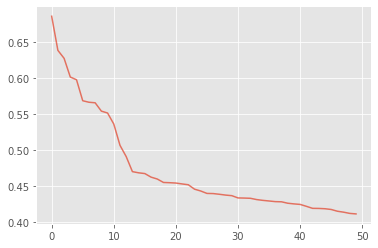

In [8]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use("ggplot")

df["similarity"].plot(alpha=0.75, rot=0)
plt.show()

Notice the inflection points at approximately `0.57` and again at `0.47` in that plot.
We could use some statistical techniques (e.g., clustering) to segment the similarities into a few groups:

  * potential synonyms for the query
  * potential [hypernyms and hyponyms](https://en.wikipedia.org/wiki/Hyponymy_and_hypernymy) for the query
  * other ingredients that pair well with the query

In this example, below a threshold of the 75th percentile for vector embedding similarity, the related ingredients are less about being synonyms and more about other foods that pair well with basil.

Let's define another function `rank_related()` which ranks the related ingredients based on a combination of these two metrics.
This uses a cheap approximation of a [*pareto archive*](https://www.cs.bham.ac.uk/~jdk/multi/) for the ranking -- which comes in handing for recommender systems and custom search applications that must combine multiple ranking metrics:

In [9]:
import math

def rms (values):
    """calculate root mean square"""
    numer = sum([x for x in map(lambda x: float(x)**2.0, values)])
    denom = float(len(values))
    return math.sqrt(numer / denom)

def rank_related (df):
    df2 = df.copy(deep=True)
    df2["related"] = df2.apply(lambda row: rms([row[2], row[4]]), axis=1)
    return df2.sort_values(by=["related"], ascending=False)

In [10]:
rank_related(df)

,ingredient,similarity,sim_pct,levenshtein,lev_pct,related
1,dry basil,0.638763,97,0.272727,98,97.501282
4,fresh basil,0.597884,91,0.363636,96,93.533416
0,dried basil leaves,0.686203,99,0.636364,82,90.898295
2,dried rosemary,0.627676,95,0.636364,82,88.738380
9,dried parsley,0.551651,81,0.454545,92,86.674679
6,dried marjoram,0.566626,87,0.636364,82,84.536974
11,basil,0.506697,77,0.545455,90,83.752612
26,dried thyme,0.439644,47,0.454545,92,73.051352
14,dry oregano,0.468503,71,0.818182,74,72.515516
5,italian seasoning,0.568717,89,1.090909,46,70.841372


Notice how the "synonym" cases tend to move up to the top now?
Meanwhile while the "pairs well with" are in the lower half of the ranked list: `fresh mushrooms`, `italian turkey sausage`, `cooked spaghetti`, `white kidney beans`, etc.

---

## Exercises

**Exercise 1:**

Build a report for a *human-in-the-loop* reviewer, using the `rank_related()` function while iterating over `vocab` to make algorithmic suggestions for possible synonyms.

**Exercise 2:**

How would you make algorithmic suggestions for a reviewer about which ingredients could be related to a query, e.g., using the `skos:broader` and `skos:narrower` relations in the [`skos`](https://www.w3.org/2004/02/skos/) vocabulary to represent *hypernyms* and *hyponyms* respectively?
This could extend the KG to provide a kind of thesaurus about recipe ingredients.